In [1]:
import matplotlib.pyplot as plt
from keras.datasets import imdb
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dropout, Embedding, SimpleRNN, LSTM, GRU, Bidirectional, Dense, RNN
from keras.regularizers import l2
import time
import numpy as np
import matplotlib.pyplot as plt

2024-07-26 08:44:33.555937: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data analysis and preparation

In [2]:
max_features = 10000  # кількість слів, що розглядаються як особливості
maxlen = 500  # обмеження кількості слів в тексті
batch_size = 32

(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)

In [3]:
# Получение словаря индексов и слов
word_index = imdb.get_word_index() 
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in input_train[10]])
print(decoded_review)

? french horror cinema has seen something of a revival over the last couple of years with great films such as inside and ? romance ? on to the scene ? ? the revival just slightly but stands head and shoulders over most modern horror titles and is surely one of the best french horror films ever made ? was obviously shot on a low budget but this is made up for in far more ways than one by the originality of the film and this in turn is ? by the excellent writing and acting that ensure the film is a winner the plot focuses on two main ideas prison and black magic the central character is a man named ? sent to prison for fraud he is put in a cell with three others the quietly insane ? body building ? marcus and his retarded boyfriend daisy after a short while in the cell together they stumble upon a hiding place in the wall that contains an old ? after ? part of it they soon realise its magical powers and realise they may be able to use it to break through the prison walls br br black magi

### Padding

In [4]:
input_train = pad_sequences(input_train, maxlen=maxlen)
input_test = pad_sequences(input_test, maxlen=maxlen)

# Building and Comparing Recurrent Models

In [6]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

model_names = []
test_accuracies = [] 
test_losses = []

# Установим коллбэки для остановки обучения при отсутствии улучшений и уменьшения скорости обучения
early_stopping = EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6)

def plot_acc_loss_history(history, title=""):
    plt.figure(figsize=(13,3))

    plt.subplot(1,2,1)
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")  
    plt.fill_between(range(len(history.history['accuracy'])), history.history['accuracy'], history.history['val_accuracy'], alpha=0.2)
    plt.grid()
    plt.xticks(range(1, len(history.history['accuracy'])+1))
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.fill_between(range(len(history.history['loss'])), history.history['loss'], history.history['val_loss'], alpha=0.2)
    plt.grid()
    plt.xticks(range(1, len(history.history['loss'])+1))
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    if len(title):
        plt.suptitle(title, fontsize=20)
    plt.show()

def make_predictions(model, name: str):

    predictions = model.predict(input_test)

    # Для отримання зрозумілішого вигляду прогнозів, їх можна перетворити в бінарний формат:
    binary_predictions = [1 if pred > 0.5 else 0 for pred in predictions]

    # Для порівняння можна вивести деякі прогнозовані значення поряд з фактичними значеннями
    for i in range(10):
        print(f"Predicted: {binary_predictions[i]}, Actual: {y_test[i]}")

    # Додатковий крок: Оцінка моделі
    # Це дасть загальну точність моделі на тестових даних
    test_loss, test_acc = model.evaluate(input_test, y_test)
    print(name,' Test Loss: {}'.format(test_loss))
    print(name, ' Test Accuracy: {}'.format(test_acc))

## Simple RNN

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          320000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 128)               4224      
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 326,433
Trainable params: 326,433
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
782/782 [========================

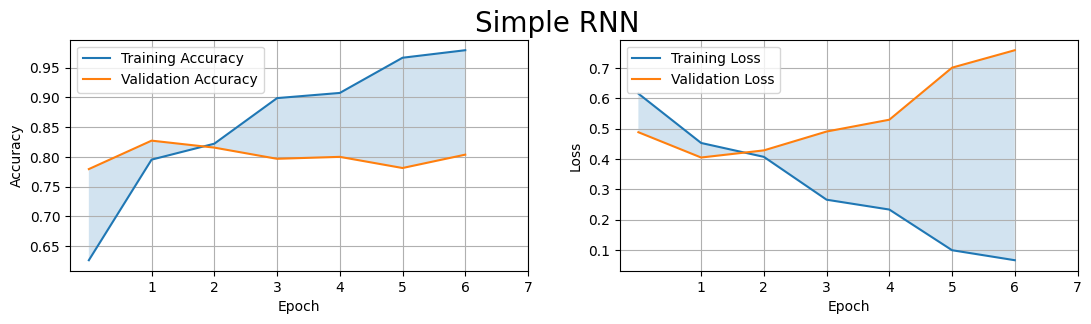

782/782 [==============================] - 10s 13ms/step
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
782/782 [==============================] - 10s 13ms/step - loss: 0.4046 - accuracy: 0.8274
Simple RNN second model  Test Loss: 0.404575377702713
Simple RNN second model  Test Accuracy: 0.8274000287055969


In [7]:
model_rnn = Sequential()
model_rnn.add(Embedding(max_features, 32))
model_rnn.add(SimpleRNN(32))
model_rnn.add(Dropout(0.5))
model_rnn.add(Dense(128, activation='relu'))
model_rnn.add(Dense(1, activation='sigmoid'))

model_rnn.compile(optimizer='adam',
                loss='binary_crossentropy', 
                metrics=['accuracy'])

print(model_rnn.summary())

start_time = time.time()
history_rnn = model_rnn.fit(
    input_train,
    y_train,
    epochs=150,  # Значение может быть изменено в зависимости от задачи и доступных ресурсов
    validation_data=(input_test, y_test),
    callbacks=[early_stopping, reduce_lr],
)
end_time = time.time()
rnn_training_time = end_time - start_time

test_loss_rnn, test_acc_rnn = model_rnn.evaluate(input_test, y_test)
model_names.append("Simple RNN")
test_accuracies.append(test_loss_rnn)
test_losses.append(test_acc_rnn)
print(f"Simple RNN Model training time: {rnn_training_time:.2f} seconds")


plot_acc_loss_history(history_rnn, "Simple RNN")
make_predictions(model_rnn, "Simple RNN second model")

## GRU

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          320000    
                                                                 
 gru (GRU)                   (None, 32)                6336      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 128)               4224      
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 330,689
Trainable params: 330,689
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150


2024-07-26 09:55:53.502293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-26 09:55:53.504808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-26 09:55:53.505556: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

782/782 [==============================] - ETA: 0s - loss: 0.6045 - accuracy: 0.7198

2024-07-26 09:57:12.310893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-26 09:57:12.311958: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-26 09:57:12.312916: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

782/782 [==============================] - 94s 118ms/step - loss: 0.6045 - accuracy: 0.7198 - val_loss: 0.3549 - val_accuracy: 0.8633 - lr: 0.0010
Epoch 2/150
782/782 [==============================] - 92s 118ms/step - loss: 0.3041 - accuracy: 0.8913 - val_loss: 0.3414 - val_accuracy: 0.8661 - lr: 0.0010
Epoch 3/150
782/782 [==============================] - 96s 122ms/step - loss: 0.2514 - accuracy: 0.9164 - val_loss: 0.3238 - val_accuracy: 0.8741 - lr: 0.0010
Epoch 4/150
782/782 [==============================] - 237s 304ms/step - loss: 0.2061 - accuracy: 0.9346 - val_loss: 0.3429 - val_accuracy: 0.8680 - lr: 0.0010
Epoch 5/150
782/782 [==============================] - 93s 120ms/step - loss: 0.1820 - accuracy: 0.9443 - val_loss: 0.3630 - val_accuracy: 0.8653 - lr: 0.0010
Epoch 6/150
782/782 [==============================] - 94s 120ms/step - loss: 0.1693 - accuracy: 0.9500 - val_loss: 0.4214 - val_accuracy: 0.8479 - lr: 0.0010
Epoch 7/150
782/782 [==============================] - 95

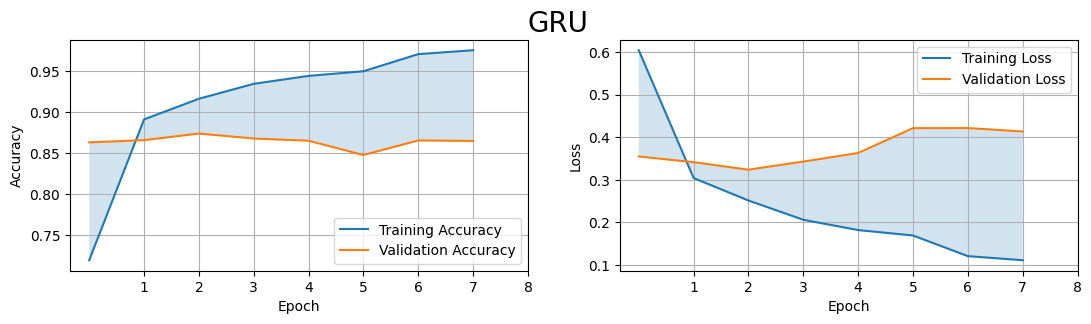

2024-07-26 10:11:09.055915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-26 10:11:09.058903: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-26 10:11:09.059844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

782/782 [==============================] - 17s 21ms/step
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
782/782 [==============================] - 16s 21ms/step - loss: 0.3238 - accuracy: 0.8741
GRU  Test Loss: 0.32381442189216614
GRU  Test Accuracy: 0.8740800023078918


In [8]:
model_gru = Sequential()
model_gru.add(Embedding(max_features, 32))
model_gru.add(GRU(32, kernel_regularizer=l2(0.01)))
model_gru.add(Dropout(0.5))
model_gru.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model_gru.add(Dense(1, activation='sigmoid'))

model_gru.compile(optimizer='adam',
                loss='binary_crossentropy', 
                metrics=['accuracy'])

print(model_gru.summary())

start_time = time.time()
history_gru = model_gru.fit(
    input_train,
    y_train,
    epochs=150, 
    validation_data=(input_test, y_test),
    callbacks=[early_stopping, reduce_lr],
)
end_time = time.time()
gru_training_time = end_time - start_time

test_loss_gru, test_acc_gru = model_gru.evaluate(input_test, y_test)
model_names.append("GRU")
test_accuracies.append(test_loss_gru)
test_losses.append(test_acc_gru)
print(f"GRU Model training time: {gru_training_time:.2f} seconds")



plot_acc_loss_history(history_gru, "GRU")
make_predictions(model_gru, "GRU")

## LSTM

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 32)          320000    
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 128)               4224      
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 332,673
Trainable params: 332,673
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150


2024-07-26 10:11:42.169051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-26 10:11:42.170302: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-26 10:11:42.171083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

782/782 [==============================] - ETA: 0s - loss: 0.5710 - accuracy: 0.7620

2024-07-26 10:12:57.979976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-26 10:12:57.981217: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-26 10:12:57.982121: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

782/782 [==============================] - 95s 120ms/step - loss: 0.5710 - accuracy: 0.7620 - val_loss: 0.3478 - val_accuracy: 0.8644 - lr: 0.0010
Epoch 2/150
782/782 [==============================] - 93s 119ms/step - loss: 0.3061 - accuracy: 0.8935 - val_loss: 0.3469 - val_accuracy: 0.8608 - lr: 0.0010
Epoch 3/150
782/782 [==============================] - 275s 352ms/step - loss: 0.2451 - accuracy: 0.9219 - val_loss: 0.3376 - val_accuracy: 0.8716 - lr: 0.0010
Epoch 4/150
782/782 [==============================] - 186s 238ms/step - loss: 0.2081 - accuracy: 0.9367 - val_loss: 0.3440 - val_accuracy: 0.8712 - lr: 0.0010
Epoch 5/150
782/782 [==============================] - 291s 372ms/step - loss: 0.1871 - accuracy: 0.9446 - val_loss: 0.4387 - val_accuracy: 0.8512 - lr: 0.0010
Epoch 6/150
782/782 [==============================] - 95s 122ms/step - loss: 0.1719 - accuracy: 0.9500 - val_loss: 0.3742 - val_accuracy: 0.8654 - lr: 0.0010
Epoch 7/150
782/782 [==============================] - 

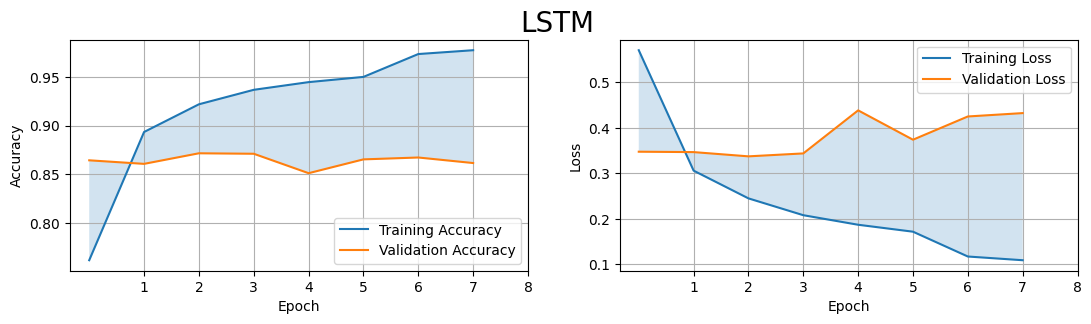

2024-07-26 10:32:29.515579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-26 10:32:29.518978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-26 10:32:29.519859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

782/782 [==============================] - 21s 26ms/step
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
782/782 [==============================] - 21s 26ms/step - loss: 0.3376 - accuracy: 0.8716
LSTM  Test Loss: 0.3375777304172516
LSTM  Test Accuracy: 0.8716400265693665


In [9]:
model_lstm = Sequential()
model_lstm.add(Embedding(max_features, 32))
model_lstm.add(LSTM(32, kernel_regularizer=l2(0.01)))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.compile(optimizer='adam',
                loss='binary_crossentropy', 
                metrics=['accuracy'])

print(model_lstm.summary())


start_time = time.time()
history_lstm = model_lstm.fit(
    input_train,
    y_train,
    epochs=150,  # Значение может быть изменено в зависимости от задачи и доступных ресурсов
    validation_data=(input_test, y_test),
    callbacks=[early_stopping, reduce_lr],
)
end_time = time.time()
lstm_training_time = end_time - start_time

test_loss_lstm, test_acc_lstm = model_lstm.evaluate(input_test, y_test)
model_names.append("LSTM")
test_accuracies.append(test_loss_lstm)
test_losses.append(test_acc_lstm)

print(f"LSTM Model training time: {lstm_training_time:.2f} seconds")



plot_acc_loss_history(history_lstm, "LSTM")
make_predictions(model_lstm, "LSTM")

## Bidirectional

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 32)          320000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 128)               8320      
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 345,089
Trainable params: 345,089
Non-trainable params: 0
________________________________________________

2024-07-26 10:33:10.965219: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-26 10:33:10.967007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-26 10:33:10.967793: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

None
Epoch 1/150


2024-07-26 10:33:11.348587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-26 10:33:11.349703: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-26 10:33:11.350742: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

782/782 [==============================] - ETA: 0s - loss: 0.6340 - accuracy: 0.7474

2024-07-26 10:34:52.966723: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-26 10:34:52.967908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-26 10:34:52.968958: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

782/782 [==============================] - 125s 156ms/step - loss: 0.6340 - accuracy: 0.7474 - val_loss: 0.4076 - val_accuracy: 0.8348 - lr: 0.0010
Epoch 2/150
782/782 [==============================] - 124s 159ms/step - loss: 0.3015 - accuracy: 0.8976 - val_loss: 0.3307 - val_accuracy: 0.8696 - lr: 0.0010
Epoch 3/150
782/782 [==============================] - 124s 159ms/step - loss: 0.2392 - accuracy: 0.9236 - val_loss: 0.3824 - val_accuracy: 0.8624 - lr: 0.0010
Epoch 4/150
782/782 [==============================] - 124s 159ms/step - loss: 0.2108 - accuracy: 0.9339 - val_loss: 0.3469 - val_accuracy: 0.8718 - lr: 0.0010
Epoch 5/150
782/782 [==============================] - 950s 1s/step - loss: 0.1876 - accuracy: 0.9460 - val_loss: 0.3513 - val_accuracy: 0.8690 - lr: 0.0010
Epoch 6/150
782/782 [==============================] - 114s 145ms/step - loss: 0.1275 - accuracy: 0.9702 - val_loss: 0.4128 - val_accuracy: 0.8668 - lr: 2.0000e-04
Epoch 7/150
782/782 [==============================

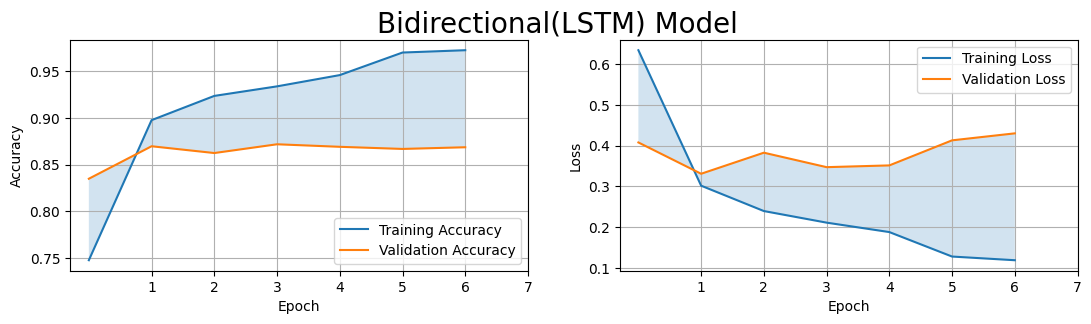

2024-07-26 11:01:38.199727: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-26 11:01:38.203763: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-26 11:01:38.206332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

782/782 [==============================] - 24s 30ms/step
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
782/782 [==============================] - 24s 30ms/step - loss: 0.3307 - accuracy: 0.8696
Bidirectional(LSTM) Model  Test Loss: 0.33074232935905457
Bidirectional(LSTM) Model  Test Accuracy: 0.8696399927139282


In [10]:
model_bd = Sequential()
model_bd.add(Embedding(max_features, 32))
model_bd.add(Bidirectional(LSTM(32, kernel_regularizer=l2(0.01))))  # Двунаправленный слой LSTM
model_bd.add(Dropout(0.5))
model_bd.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model_bd.add(Dense(1, activation='sigmoid'))

model_bd.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

print(model_bd.summary())

start_time = time.time()
history_bd = model_bd.fit(
    input_train,
    y_train,
    epochs=150,  # Значение может быть изменено в зависимости от задачи и доступных ресурсов
    validation_data=(input_test, y_test),
    callbacks=[early_stopping, reduce_lr],
)
end_time = time.time()
bd_training_time = end_time - start_time

test_loss_bd, test_acc_bd = model_bd.evaluate(input_test, y_test)
model_names.append("Bidirectional(LSTM) Model")
test_accuracies.append(test_loss_lstm)
test_losses.append(test_acc_lstm)

print(f"Bidirectional(LSTM) Model training time: {lstm_training_time:.2f} seconds")



plot_acc_loss_history(history_bd, "Bidirectional(LSTM) Model")
make_predictions(model_bd, "Bidirectional(LSTM) Model")

## Deep Bidirectional Recurrent Neural Network (Deep BRNN)

2024-07-26 11:04:33.609801: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-26 11:04:33.610726: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-26 11:04:33.611745: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 32)          320000    
                                                                 
 bidirectional_3 (Bidirectio  (None, None, 128)        49664     
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, None, 128)         0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 128)              

2024-07-26 11:04:33.929238: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-26 11:04:33.930283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-26 11:04:33.931149: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

None
Epoch 1/150


2024-07-26 11:04:34.327711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-26 11:04:34.329080: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-26 11:04:34.330324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

782/782 [==============================] - ETA: 0s - loss: 0.6906 - accuracy: 0.6531

2024-07-26 11:10:16.697047: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-26 11:10:16.700470: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-26 11:10:16.701522: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

782/782 [==============================] - 443s 560ms/step - loss: 0.6906 - accuracy: 0.6531 - val_loss: 0.6992 - val_accuracy: 0.6422 - lr: 0.0010
Epoch 2/150
782/782 [==============================] - 489s 626ms/step - loss: 0.5314 - accuracy: 0.7472 - val_loss: 0.4225 - val_accuracy: 0.8085 - lr: 0.0010
Epoch 3/150
782/782 [==============================] - 880s 1s/step - loss: 0.3999 - accuracy: 0.8476 - val_loss: 0.3819 - val_accuracy: 0.8497 - lr: 0.0010
Epoch 4/150
782/782 [==============================] - 1748s 2s/step - loss: 0.2998 - accuracy: 0.8936 - val_loss: 0.3430 - val_accuracy: 0.8618 - lr: 0.0010
Epoch 5/150
782/782 [==============================] - 3264s 4s/step - loss: 0.2381 - accuracy: 0.9203 - val_loss: 0.3599 - val_accuracy: 0.8717 - lr: 0.0010
Epoch 6/150
782/782 [==============================] - 621s 795ms/step - loss: 0.1982 - accuracy: 0.9370 - val_loss: 0.3451 - val_accuracy: 0.8729 - lr: 0.0010
Epoch 7/150
782/782 [==============================] - 1373

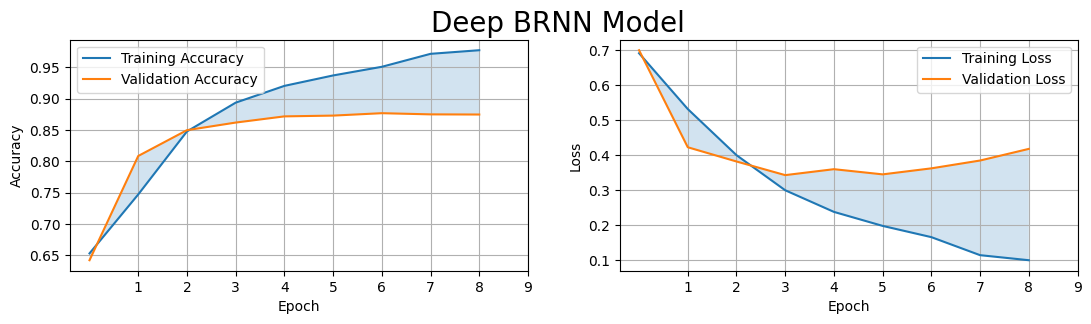

2024-07-26 14:45:39.581694: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-26 14:45:39.584854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-26 14:45:39.585842: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

782/782 [==============================] - 98s 119ms/step
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
782/782 [==============================] - 95s 122ms/step - loss: 0.3430 - accuracy: 0.8618
Deep BRNN Model  Test Loss: 0.34296661615371704
Deep BRNN Model  Test Accuracy: 0.8618000149726868


In [13]:

model_brnn = Sequential()
model_brnn.add(Embedding(max_features, 32))
model_brnn.add(Bidirectional(LSTM(64, return_sequences=True)))  # Добавление первого двунаправленного LSTM слоя
model_brnn.add(Dropout(0.5))
model_brnn.add(Bidirectional(LSTM(64)))  # Добавление второго двунаправленного LSTM слоя
model_brnn.add(Dropout(0.5))
model_brnn.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))  # Полносвязный слой
model_brnn.add(Dropout(0.5))
model_brnn.add(Dense(1, activation='sigmoid'))  # Выходной слой

model_brnn.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

print(model_brnn.summary())


start_time = time.time()
history_brnn = model_brnn.fit(
    input_train,
    y_train,
    epochs=150,  # Значение может быть изменено в зависимости от задачи и доступных ресурсов
    validation_data=(input_test, y_test),
    callbacks=[early_stopping, reduce_lr],
)
end_time = time.time()
brnn_training_time = end_time - start_time

test_loss_brnn, test_acc_brnn= model_brnn.evaluate(input_test, y_test)
model_names.append("Deep BRNN")
test_accuracies.append(test_loss_brnn)
test_losses.append(test_acc_brnn)

print(f"Deep BRNN Model training time: {brnn_training_time:.2f} seconds")



plot_acc_loss_history(history_brnn, "Deep BRNN Model")
make_predictions(model_brnn, "Deep BRNN Model")

In [15]:
model_names[3] = "Bidirectional(LSTM) Model"

# Comparison of model results

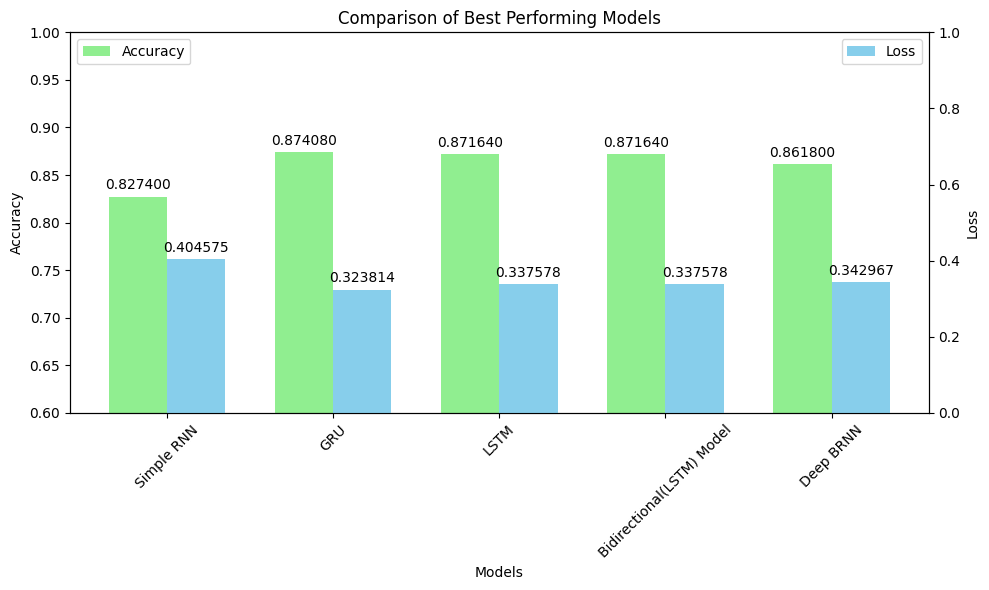

In [28]:
# Создаем фигуру с двумя осями Y
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Ширина столбцов
width = 0.35

# Позиции для столбцов
x = np.arange(len(model_names))

# Создаем столбцы для MSE и R^2
rects1 = ax1.bar(x - width/2, test_losses, width, label='Accuracy', color='lightgreen')
rects2 = ax2.bar(x + width/2, test_accuracies, width, label='Loss', color='skyblue')

# Настройка осей и меток
ax1.set_xlabel('Models')
ax1.set_ylabel('Accuracy')
ax2.set_ylabel('Loss')

ax1.set_xticks(x)
ax1.set_xticklabels(model_names, rotation=45)

ax1.set_ylim(0.6, 1)  # Устанавливаем пределы для 'Accuracy'
ax2.set_ylim(0, 1)  # Устанавливаем пределы для loss

# Добавляем значения на столбцы
def autolabel(rects, ax, fmt='{:.6f}'):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(fmt.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects2, ax2)
autolabel(rects1, ax1, fmt='{:.6f}')

# Добавляем легенду
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('Comparison of Best Performing Models')
plt.tight_layout()
plt.show()

# Conclusion

**All models showed approximately similar results:**
- Accuracy: from 0.8274 to 0.8740
- Loss: from 0.3238 to 0.4045


Analyzing the loss graphs, almost all models exhibited overfitting, except for the Deep BRNN Model.

The worst results were demonstrated by the Simple RNN, which had the lowest accuracy and the highest loss.

The GRU Model showed the best accuracy and also had the lowest loss, but it still exhibited overfitting.

The only model that did not show overfitting was the Deep BRNN Model. Since all models have very similar metrics, the Deep BRNN Model can be considered the best.


### Висновок

**Усі моделі показали приблизно однакові результати:**
- Accuracy: від 0.8274 до 0.8740
- Loss: від 0.3238 до 0.4045


За аналізом графіків втрат, майже всі моделі демонстрували перенавчання, за винятком Deep BRNN Model.

Найгірші результати продемонструвала Simple RNN, яка мала найнижчу accuracy та найвищий loss.

Найкращу точність показала GRU Model, також вона мала найменший loss, але все ж демонструвала перенавчання.

Єдина модель, яка не показала перенавчання, це Deep BRNN Model. Оскільки всі моделі мають дуже близькі показники, можна вважати Deep BRNN Model найкращою.